# SYDE 671, a2, Questions
## Tongdan Su, 20754736

Exercise

In [57]:
#!/usr/bin/env python
#coding: utf8
 
"""
Code originally by Brian R. Pauw and David Mannicke.
Modified by James Tompkin for Brown CSCI1430.
 
Initial Python coding and refactoring:
    Brian R. Pauw
With input from:
    Samuel Tardif
 
Windows compatibility resolution: 
    David Mannicke
    Chris Garvey
 
Windows compiled version:
    Joachim Kohlbrecher
"""
 
"""
Overview
========
This program uses OpenCV to capture images from the camera, Fourier transform
them and show the Fourier transformed image alongside the original on the screen.
 
$ ./liveFFT2.py
 
Required: A Python 3.x installation (tested on 3.5.3),
with: 
    - OpenCV (for camera reading)
    - numpy, matplotlib, scipy, argparse
"""
 
__author__ = "Brian R. Pauw, David Mannicke; modified for Brown CSCI1430 by James Tompkin"
__contact__ = "brian@stack.nl; james_tompkin@brown.edu"
__license__ = "GPLv3+"
__date__ = "2014/01/25; modifications 2017--2019"
__status__ = "v2.1"
 
import cv2 #opencv-based functions
import time
import math
import numpy as np
from scipy import ndimage
from matplotlib.pyplot import imread, imshow
from skimage import io
from skimage import img_as_float, img_as_ubyte
from skimage.color import rgb2gray
 
class live_FFT2():
    """
    This function shows the live Fourier transform of a continuous stream of 
    images captured from an attached camera.
 
    """
 
    wn = "FD"
    use_camera = True
    im = 0
    imJack = 0
    phaseOffset = 0
    rollOffset = 0
    # Variable for animating basis reconstruction
    amplitudeCutoffRadius = 1
    amplitudeCutoffDirection = 1
    # Variables for animated basis demo
    magnitude = 2
    orientation = 0
 
    def __init__(self, **kwargs):
 
        # Camera device
        self.vc = cv2.VideoCapture(0)
        if not self.vc.isOpened():
            print( "No camera found or error opening camera; using a static image instead." )
            self.use_camera = False
 
        if self.use_camera == True:
            # No camera!
            self.im = rgb2gray(img_as_float(io.imread('./YuanningHuCrop.png')))
        else:
            # We found a camera!
            # Requested camera size. This will be cropped square later on, e.g., 240 x 240
            ret = self.vc.set(cv2.CAP_PROP_FRAME_WIDTH, 320)
            ret = self.vc.set(cv2.CAP_PROP_FRAME_HEIGHT, 240)
 
        # Set the size of the output window
        cv2.namedWindow(self.wn, 0)
 
        # Load the Jack image for comparison
        self.imJack = rgb2gray(img_as_float(io.imread('JacksonGibbonsCrop.png')))
 
        # Main loop
        while True:
            a = time.perf_counter()
            self.camimage_ft()
            print('framerate = {} fps \r'.format(1. / (time.perf_counter() - a)))
     
     
        if self.use_camera:
            # Stop camera
            self.vc.release()
 
 
    def camimage_ft(self):
         
        if self.use_camera:
            # Read image
            rval, im = self.vc.read()
            # Convert to grayscale and crop to square
            # (not necessary as rectangular is fine; just easier for didactic reasons)
            im = img_as_float(rgb2gray(im))
            # Note: some cameras across the class are returning different image sizes
            # on first read and later on. So, let's just recompute the crop constantly.
             
            if im.shape[1] > im.shape[0]:
                cropx = int((im.shape[1]-im.shape[0])/2)
                cropy = 0
            elif im.shape[0] > im.shape[1]:
                cropx = 0
                cropy = int((im.shape[0]-im.shape[1])/2)
 
            self.im = im[cropy:im.shape[0]-cropy, cropx:im.shape[1]-cropx]
 
        # Set size
        width = self.im.shape[1]
        height = self.im.shape[0]
        cv2.resizeWindow(self.wn, width*2, height*2)
 
        #                
        # Students: Concentrate here.
        # This code reads an image from your webcam. If you have no webcam, e.g.,
        # a department machine, then it will use a picture of an intrepid HTA.
        #
        # Output image visualization:
        # Top left: input image
        # Bottom left: amplitude image of Fourier decomposition
        # Bottom right: phase image of Fourier decomposition
        # Top right: reconstruction of image from Fourier domain
        #
        # Let's start by peforming the 2D fast Fourier decomposition operation
        imFFT = np.fft.fft2( self.im )
         
        # Then creating our amplitude and phase images
        amplitude = np.sqrt( np.power( imFFT.real, 2 ) + np.power( imFFT.imag, 2 ) )
        phase = np.arctan2( imFFT.imag, imFFT.real )
         
        # We will reconstruct the image from this decomposition later on (far below); have a look now.
 
        #########################################################
        ## Part 0: Scanning the basis and looking at the reconstructed image
        #
        # # For this one, let's visually ignore the camera input.
        # # Then, let's zero out the amplitude and phase.
#         amplitude = np.zeros( self.im.shape )
#         phase = np.zeros( self.im.shape )
 
#         # Next, let's only set one basis sine wave to have any amplitude.
#         # Let's animate how it looks as we move radially through the frequency space
#         self.orientation += math.pi / 30.0
#         if self.orientation > math.pi * 2:
#             self.orientation = 0
#             self.magnitude += 2
#         if self.magnitude >= 50: # could go to width/2 for v. high frequencies
#             self.magnitude = 2
 
#         cx = math.floor(width/2)
#         cy = math.floor(height/2)
#         xd = self.magnitude*math.cos(self.orientation)
#         yd = self.magnitude*math.sin(self.orientation)
#         a = np.fft.fftshift(amplitude)
#         a[int(cy+yd), int(cx+xd)] = self.im.shape[0]*self.im.shape[1] / 2.0
#         amplitude = np.fft.fftshift(a)
 
 
# #         ########################################################
#         # Part 1: Reconstructing from different numbers of basis frequencies
        
#         # What if we set some amplitudes to zero, but vary
#         # over time which ones we set?
 
#         # Make a circular mask over the amplitude image
#         Y, X = np.ogrid[:height, :width]
#         dist_from_center = np.sqrt((X-(width/2))**2 + (Y-(height/2))**2)
#         # Suppress amplitudes less than cutoff radius
#         mask = dist_from_center >= self.amplitudeCutoffRadius
#         a = np.fft.fftshift(amplitude)
#         a[mask] = 0
#         amplitude = np.fft.fftshift(a)
 
#         # Slowly undulate the cutoff radius back and forth
#         # If radius is small and direction is decreasing, then flip the direction!
#         if self.amplitudeCutoffRadius <= 1 and self.amplitudeCutoffDirection < 0:
#             self.amplitudeCutoffDirection *= -1
#         # If radius is large and direction is increasing, then flip the direction!
#         if self.amplitudeCutoffRadius > width/3 and self.amplitudeCutoffDirection > 0:
#             self.amplitudeCutoffDirection *= -1
         
#         self.amplitudeCutoffRadius += self.amplitudeCutoffDirection
 
 
# #         ########################################################
# #         # Part 2: Replacing amplitude / phase with that of another image
        
        imJack = cv2.resize( self.imJack, self.im.shape )
        imJackFFT = np.fft.fft2( imJack )
        amplitudeJack = np.sqrt( np.power( imJackFFT.real, 2 ) + np.power( imJackFFT.imag, 2 ) )
        phaseJack = np.arctan2( imJackFFT.imag, imJackFFT.real )
         
        # Comment in either or both of these
        amplitude = amplitudeJack
   #     phase = phaseJack
 
 
#         ########################################################
# #         # Part 3: Replacing amplitude / phase with that of a noisy image
         
# # #         # Generate some noise
#         self.uniform_noise = np.random.uniform( 0, 1, self.im.shape )
#         imNoiseFFT = np.fft.fft2( self.uniform_noise )
#         amplitudeNoise = np.sqrt( np.power( imNoiseFFT.real, 2 ) + np.power( imNoiseFFT.imag, 2 ) )
#         phaseNoise = np.arctan2( imNoiseFFT.imag, imNoiseFFT.real )
         
#         # Comment in either or both of these
#         amplitude = amplitudeNoise
#         phase = phaseNoise
 
 
#         ########################################################
#         # Part 4: Understanding amplitude and phase
        
# #         Play with the images. What can you discover?
         
#         Zero out phase?
#        phase = np.zeros( self.im.shape )
 
# #         Flip direction?
#        phase = -phase
 
#         # Rotate phase values?
#         self.phaseOffset += 0.05
# #         phase = np.arctan2( imFFT.imag, imFFT.real ) + self.phaseOffset
# #         # Always place within -pi to pi
#         phase += np.pi
#         phase %= 2*np.pi
#         phase -= np.pi
 
# #        Rotate whole image? Together? Individually?
#         phase = np.rot90( phase )
#         amplitude = np.rot90( amplitude )
         
#         Are these manipulations meaningful?
#         What other manipulations might we perform?
 
 
        ########################################################
        ## Reconstruct the original image
        # I need to build a new real+imaginary number from the amplitude / phase
        # This is going from polar coordinates to Cartesian coordinates in the complex number space
        recReal = np.cos( phase ) * amplitude
        recImag = np.sin( phase ) * amplitude
        rec = recReal + 1j*recImag
        # Now inverse Fourier transform
        newImage = np.fft.ifft2( rec ).real
         
        # Image output
        amplitude[amplitude == 0] = np.finfo(float).eps # prevent any log(0) errors
        outputTop = np.concatenate((self.im,newImage),axis = 1)
        outputBottom = np.concatenate((np.log(np.fft.fftshift(amplitude)) / 10, np.fft.fftshift(phase)),axis = 1)
        output = np.clip(np.concatenate((outputTop,outputBottom),axis = 0),0,1)
        # NOTE: One student's software crashed at this line without casting to uint8,
        # but this operation via img_as_ubyte is _slow_. Add this back in if you code crashes.
#         cv2.imshow(self.wn, output)
#         cv2.imshow(self.wn, img_as_ubyte(output))
        #print(output)
        cv2.imshow(self.wn, (output*255).astype(np.uint8)) # faster alternative
        #print(2223)
        cv2.waitKey(1)
 
        return
 
if __name__ == '__main__':
    live_FFT2()

framerate = 5.659133416899054 fps 
framerate = 6.5180677579179225 fps 
framerate = 6.228872443300995 fps 
framerate = 6.24299224122727 fps 
framerate = 6.551392727807008 fps 
framerate = 6.436634232444869 fps 
framerate = 5.6115967012958885 fps 
framerate = 5.789569973919914 fps 
framerate = 5.756455865252615 fps 
framerate = 6.04677543607527 fps 
framerate = 4.931255828119186 fps 
framerate = 5.995110387976368 fps 
framerate = 5.961315829336341 fps 
framerate = 6.5215449018440275 fps 
framerate = 6.496995464443125 fps 
framerate = 6.395988436072331 fps 
framerate = 6.384464809463984 fps 
framerate = 6.644942135830282 fps 
framerate = 6.465846107685505 fps 
framerate = 6.342252019562217 fps 
framerate = 6.494965752052608 fps 
framerate = 6.41560686184961 fps 
framerate = 6.546237713539752 fps 
framerate = 6.341725126808675 fps 
framerate = 6.2432027130716445 fps 
framerate = 5.8924741320262255 fps 
framerate = 5.88365080535236 fps 
framerate = 5.8536802380455555 fps 
framerate = 5.8136

KeyboardInterrupt: 

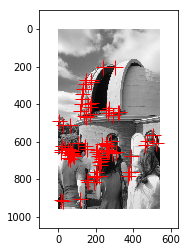

In [64]:
from matplotlib import pyplot as plt 
from skimage import io, color, transform
from skimage.feature import corner_harris, peak_local_max
 
# load in different images to see where the Harris Corner Detector finds corners
image = transform.rescale(color.rgb2gray(io.imread("LaddObservatory2.jpg")),0.25)
 
harris_response = corner_harris(image)
# Note: Feel free to play with these parameters to investigate their effects
coords = peak_local_max( harris_response, min_distance=5, threshold_rel=0.05 )
 
plt.imshow(image, cmap=plt.cm.gray)
plt.plot(coords[:, 1], coords[:, 0], '+r', markersize=15)
plt.axis((-100, image.shape[1]+100, image.shape[0]+100, -100))
plt.show()